In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,train_test_split
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/creditcardfraud/creditcard.csv


## Reading Data

In [2]:
path="/kaggle/input/creditcardfraud/creditcard.csv"
data=pd.read_csv(path)

## Dataset Information

In [3]:
usage=data.memory_usage(index=False)
TO_MB=(1024)**2
print(f"All Columns Has Same Size Of {round(usage[0]/TO_MB)} MB \n The Sum Of Total Memory Usage Is {round(sum(usage)/TO_MB)} MB")

All Columns Has Same Size Of 2 MB 
 The Sum Of Total Memory Usage Is 67 MB


In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data[["Time","Amount","Class"]].describe().T.style.background_gradient(subset="mean",axis=0,cmap="bwr",vmin=.5,vmax=1,low=.4,high=.8)\
                        .background_gradient(subset=["std","50%"],axis=0,cmap="bwr")\
                        .background_gradient(subset="max",axis=0,cmap="Blues_r",low=.2,high=.9)

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
Amount,284807.000000,88.349619,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000
Class,284807.000000,0.001727,0.041527,0.000000,0.000000,0.000000,0.000000,1.000000


492 Of Frauds
284315 No Frauds


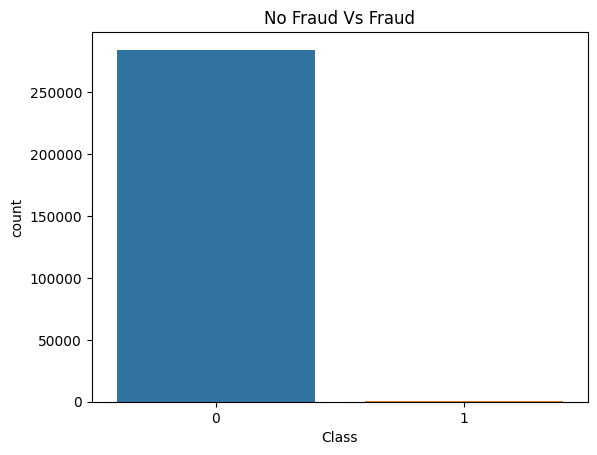

In [7]:
fraud=len(data[data["Class"]==1])
no_fraud=len(data[data["Class"]==0])
print(f"{fraud} Of Frauds")
print(f"{no_fraud} No Frauds")
sns.countplot(data=data,x="Class")
plt.title("No Fraud Vs Fraud")
plt.show()

## EDA

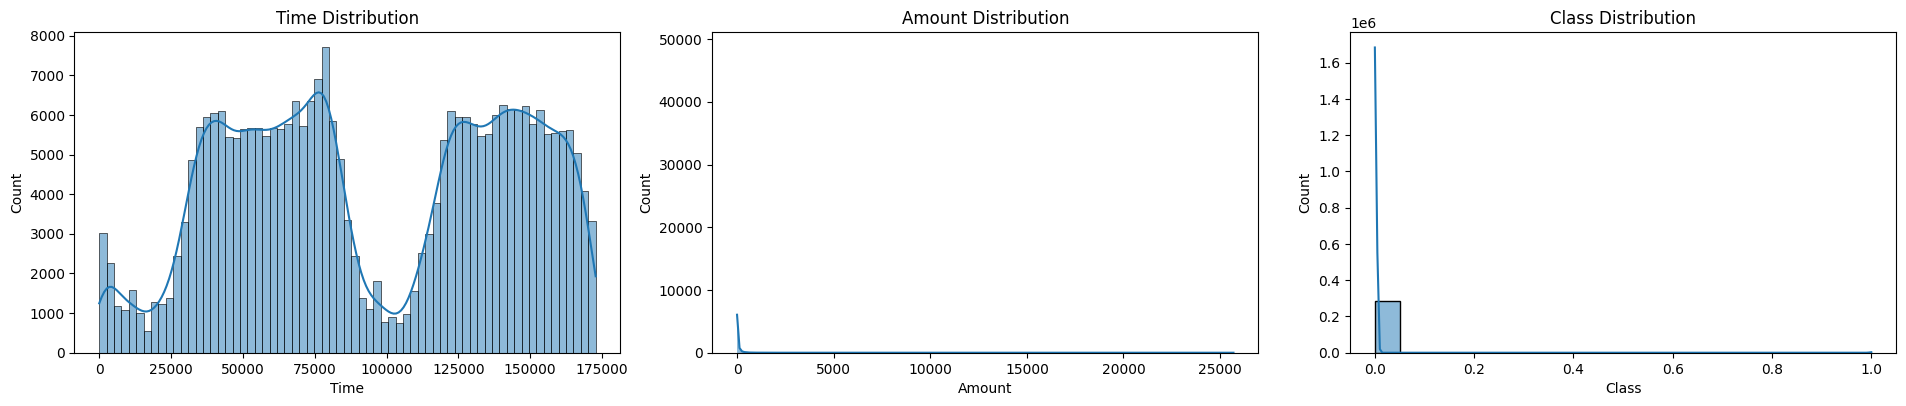

In [8]:
fig,axs=plt.subplots(1,3,figsize=(19,4))
sns.histplot(data["Time"],ax=axs[0],kde=True)
axs[0].set_title("Time Distribution")

sns.histplot(data["Amount"],ax=axs[1],kde=True)
axs[1].set_title("Amount Distribution")

sns.histplot(data["Class"],ax=axs[2],kde=True)
axs[2].set_title("Class Distribution")
plt.tight_layout(pad=.5)
plt.show()

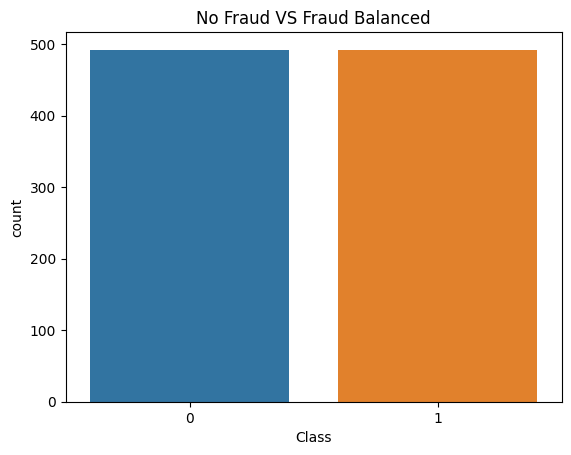

In [9]:
# Do A random Sampling
fraud_df=data.loc[data["Class"]==0][:492]
no_fraud_df=data.loc[data["Class"]==1]
new_norm_dist_df=pd.concat([fraud_df,no_fraud_df])
sns.countplot(data=new_norm_dist_df,x="Class")
plt.title("No Fraud VS Fraud Balanced")
plt.show()

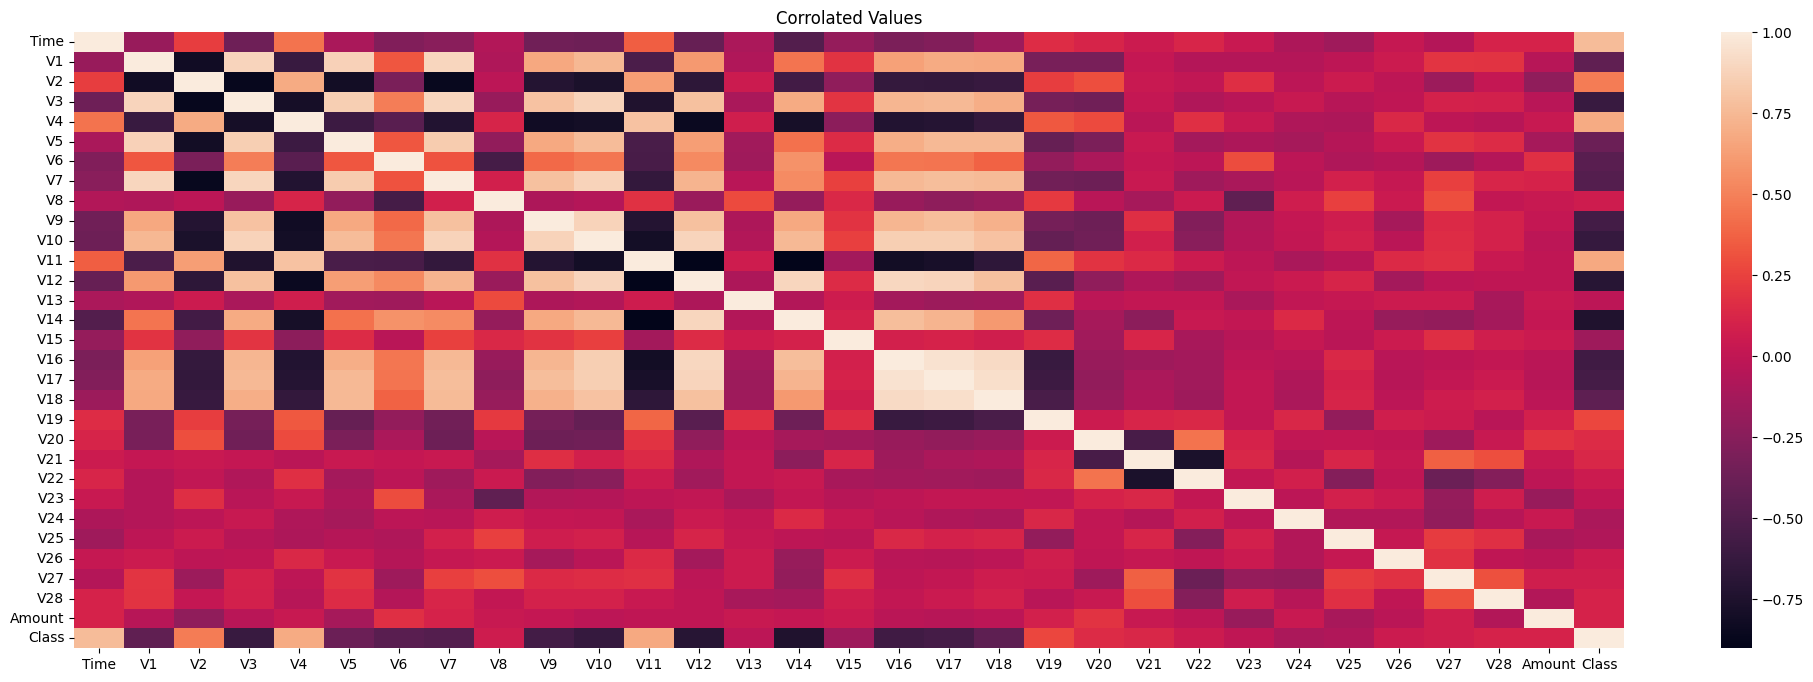

In [10]:
sns.color_palette(palette="husl",n_colors=10)
plt.figure(figsize=(25,8))
corr_data=new_norm_dist_df.corr()
sns.heatmap(data=corr_data)
plt.title("Corrolated Values")
plt.show()

<ul>
    <li>V3,V5,V17,V18 Are Negatively Corrolated</li>
    <li>V2,V4,V11,V19 Are Positively Corrolated</li>
</ul>

<h3> Detecting Outliers </h3>

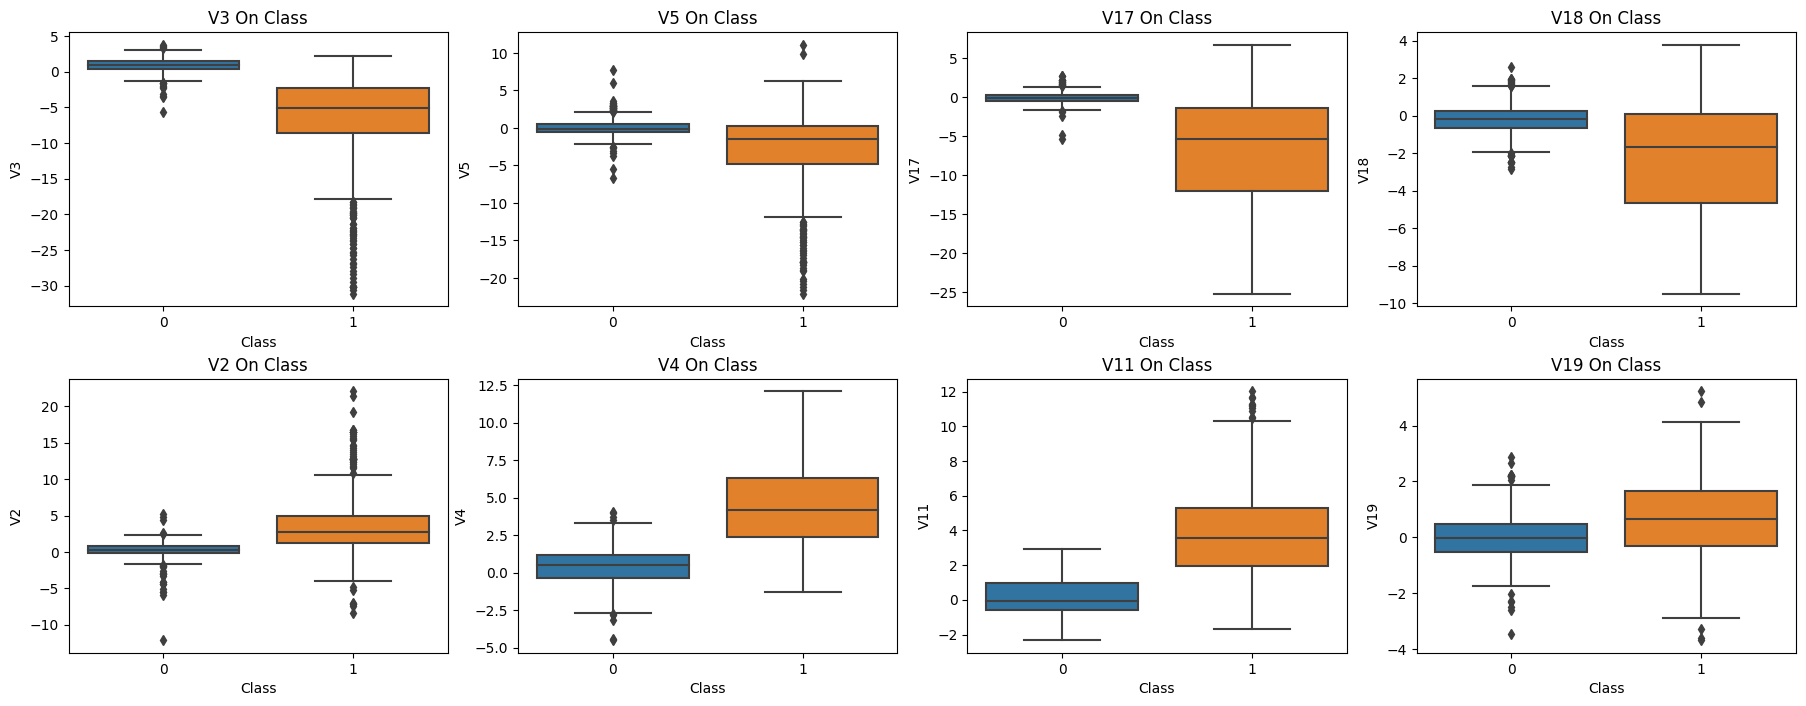

In [11]:
negative_corr_cols=["V3","V5","V17","V18"]
positive_corr_cols=["V2","V4","V11","V19"]

fig,axs=plt.subplots(nrows=2,ncols=4,figsize=(18,7))
sns.boxplot(ax=axs[0,0],data=new_norm_dist_df,x="Class",y=negative_corr_cols[0])
axs[0,0].set_title("V3 On Class")

sns.boxplot(ax=axs[0,1],data=new_norm_dist_df,x="Class",y=negative_corr_cols[1])
axs[0,1].set_title("V5 On Class")

sns.boxplot(ax=axs[0,2],data=new_norm_dist_df,x="Class",y=negative_corr_cols[2])
axs[0,2].set_title("V17 On Class")

sns.boxplot(ax=axs[0,3],data=new_norm_dist_df,x="Class",y=negative_corr_cols[3])
axs[0,3].set_title("V18 On Class")

sns.boxplot(ax=axs[1,0],data=new_norm_dist_df,x="Class",y=positive_corr_cols[0])
axs[1,0].set_title("V2 On Class")

sns.boxplot(ax=axs[1,1],data=new_norm_dist_df,x="Class",y=positive_corr_cols[1])
axs[1,1].set_title("V4 On Class")

sns.boxplot(ax=axs[1,2],data=new_norm_dist_df,x="Class",y=positive_corr_cols[2])
axs[1,2].set_title("V11 On Class")

sns.boxplot(ax=axs[1,3],data=new_norm_dist_df,x="Class",y=positive_corr_cols[3])
axs[1,3].set_title("V19 On Class")

plt.tight_layout(pad=.5)
plt.show()

## Detecting Outliers

In [12]:
def outliers_iqr(data):
    """This Function Detects And Extracts Outliers 
    And Append It To A List"""
    
    outliers=[]
    const_iqr=1.5
    data=sorted(data)
    
    #Get The Percentiles 25% And 75%
    Q_1=np.percentile(data,25)
    Q_3=np.percentile(data,75)
    
    #Calculate IQR
    IQR=Q_3-Q_1
    lower_bound=Q_1-(IQR*const_iqr)
    upper_bound=Q_3+(IQR*const_iqr)
    
    #Iterate Over Data And Look For Outliers
    for _,d in enumerate(data):
        if(d<lower_bound or d>upper_bound):
            outliers.append(d)

    return outliers

In [13]:
for pos,neg in tqdm(zip(positive_corr_cols,negative_corr_cols)):
    print(f"There Are {len(outliers_iqr(new_norm_dist_df[pos]))} Outliers In The {pos} From Positive Corrolation")
    print(f"There Are {len(outliers_iqr(new_norm_dist_df[neg]))} Outliers In The {neg} From Negative Corrolation")

4it [00:00, 271.36it/s]

There Are 107 Outliers In The V2 From Positive Corrolation
There Are 71 Outliers In The V3 From Negative Corrolation
There Are 27 Outliers In The V4 From Positive Corrolation
There Are 135 Outliers In The V5 From Negative Corrolation
There Are 22 Outliers In The V11 From Positive Corrolation
There Are 81 Outliers In The V17 From Negative Corrolation
There Are 33 Outliers In The V19 From Positive Corrolation
There Are 93 Outliers In The V18 From Negative Corrolation


In [14]:
#The Percentiles of V2
V2_Q1,V2_Q3=np.percentile(new_norm_dist_df["V2"],25),\
            np.percentile(new_norm_dist_df["V2"],75)
#The Percentiles of V5
V5_Q1,V5_Q3=np.percentile(new_norm_dist_df["V5"],25)\
            ,np.percentile(new_norm_dist_df["V5"],75)
#The Percentiles of V3
V3_Q1,V3_Q3=np.percentile(new_norm_dist_df["V3"],25),\
            np.percentile(new_norm_dist_df["V3"],75)

#Calculate V2 And Replace Outliers With Median On V2 Column
IQR_V2=V2_Q3-V2_Q1
V2_lower=V2_Q1-(IQR_V2*1.5)
V2_upper=V2_Q3+(IQR_V2*1.5)
new_norm_dist_df["V2"]=np.where((new_norm_dist_df["V2"]>V2_upper)|(new_norm_dist_df["V2"]<V2_lower)\
                          ,np.median(new_norm_dist_df["V2"]),new_norm_dist_df["V2"])

#Calculate V5 And Replace Outliers With Median On V5 Column
IQR_V5=V5_Q3-V5_Q1
V5_lower=V5_Q1-(IQR_V5*1.5)
V5_upper=V5_Q3+(IQR_V5*1.5)
new_norm_dist_df["V5"]=np.where(new_norm_dist_df["V5"]<V5_lower\
                          ,np.median(new_norm_dist_df["V5"]),new_norm_dist_df["V5"])

#Calculate V3 And Replace Outliers With Median On V3 Column
IQR_V3=V3_Q3-V3_Q1
V3_lower=V3_Q1-(IQR_V3*1.5)
#V3_upper=V3_Q3+(IQR_V3*1.5)
new_norm_dist_df["V3"]=np.where(new_norm_dist_df["V3"]<V3_lower\
                          ,np.median(new_norm_dist_df["V3"]),new_norm_dist_df["V3"])

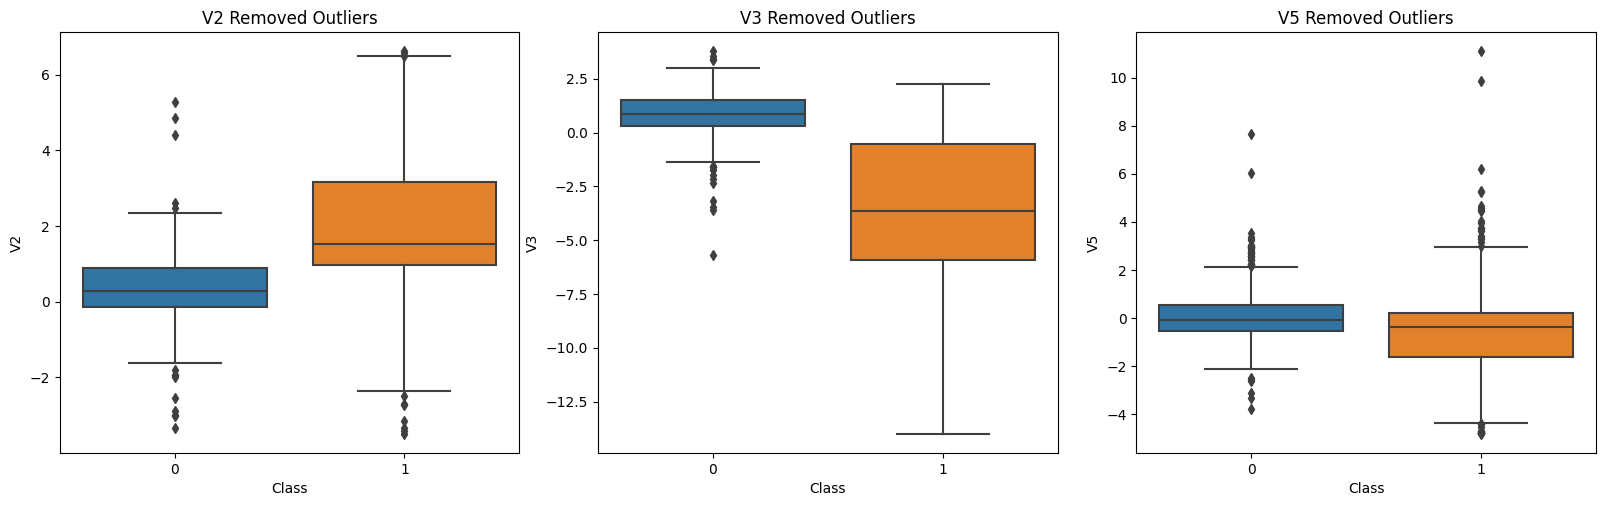

In [15]:
fig,axs=plt.subplots(1,3,figsize=(16,5))

sns.boxplot(ax=axs[0],data=new_norm_dist_df,x="Class",y="V2")
axs[0].set_title("V2 Removed Outliers")
sns.boxplot(ax=axs[1],data=new_norm_dist_df,x="Class",y="V3")
axs[1].set_title("V3 Removed Outliers")
sns.boxplot(ax=axs[2],data=new_norm_dist_df,x="Class",y="V5")
axs[2].set_title("V5 Removed Outliers")
plt.tight_layout(pad=.5)
plt.show()

## Scaling

In [16]:
new_norm_dist_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
# Set The Robust And Standard Scaler
stsc=StandardScaler()
rbsc=RobustScaler()

# Scale The Time And Amount Columns
new_norm_dist_df["Scaled Amount"]=stsc.fit_transform(new_norm_dist_df["Amount"].values.reshape(-1,1))
new_norm_dist_df["Scaled Time"]=rbsc.fit_transform(new_norm_dist_df["Time"].values.reshape(-1,1))

#Drop The Unscaled Data
new_norm_dist_df.drop(columns=["Time","Amount"],axis=1,inplace=True)

## Prediction

In [18]:
X=new_norm_dist_df.drop(columns="Class",axis=1)
y=new_norm_dist_df["Class"]

In [19]:
skf=StratifiedKFold(n_splits=5)
for i,(train_index,test_index)in enumerate(skf.split(X,y)):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    